As a first step I want to prepare the pdbbind data for the runner. Steps:

- Check index file annotations and remove flagged complexes if needed
    - X-mer as name (I dont want peptides)
    - covalent complexes
    - incomplete ligands
    - redundant entries
- Check if the mol2 is parsable and contains hydrogens
    - it is not, so I will need to use the sdfs
- Apply ligand filters
    - Number of heavy atoms
    - QED values?
    - Rare elements
- Clean the pdb files
    - Remove all chains without ligand contact
    - Remove all hetero atoms without ligand contact and all waters
    - Flag structures with water close to the ligand
- Check for total size of protein and remove too large ones

Repeat on Astex and posebuster files, but without removing entries for now. Only flag them.

Hydrogen investigations:
- Does Rosetta change hydrogens on ligands?
    - I don't think so, but I will stick to placing hydrogens using Roccos reprotonate function. Therefore I will ignore hydrogens depending on the input
- Do pdb files contain hydrogens? Does Rosetta alter them?
    - Same as above, I don't think so. But since hydrogens are not resolved during experiments, I will allow Rosetta to place them
- Is there a difference between pdbbind mol2 and the rcsb pdb ligand file?
    - Yes, big time. PDBBind, rscb, sdf, mol2, CCD, all disagree with each other. I will therefore only consider heavy atoms and use a standardized pipeline to automatically place hydrogens. This might be wrong, but it is an end-to-end pipeline and I will assess the perfomance solely based on the ability to calculate heavy atom positions

Following the last point above (disagreement between different file sources), I will also only use kekule structures, as this is generally easier to obtain.

In [5]:
removed_ids = []
pdb_ids = []

# filter based on pdbbind index file

remove_flags = ['peptide (xmer)', 'covalent', 'incomplete ligand', 'redundant', 'resolution', 'NMR']
remove_counter = {}
for f in remove_flags:
    remove_counter[f] = 0
allowed_flags = ['ligand is', 'kd', 'ic50', 'ki', '+/-', 'ph', 'isomer', 'contain', 'temp', 'kon', 'koff',
                 'supplementary information', 'crystal', 'complex', 'mm',
                'fragment', 'affinity',
                'assay',
                'binding',
                'bortezomib',
                'carfilzomib',
                'compound ',
                'mutation: yes',
                'residues ',
                'different ligand structure']
unknown_flags = {}

with open('pdbbind_2020plus/INDEX_general_PL.2020R1.lst') as file:
    for line in file:
        if line[0] == '#':
            continue
        line = line.strip().split('//')
        pdb_id = line[0].split()[0]
        resolution = line[0].split()[1]
        ligand_name = line[1].split('(')[1].split(')')[0]
        flags = ''.join(line[1].split(')')[1:]).strip().split(';')
        if flags[0] == '' and len(flags) == 1:
            flags = []
        if ligand_name[-3:] == 'mer':
            flags.append('peptide (xmer)')
        removed = False
        for f in flags:
            f = f.strip().lower()
            for remove_flag in remove_flags:
                if remove_flag in f:
                    removed_ids.append((pdb_id, remove_flag))
                    remove_counter[remove_flag] += 1
                    removed = True
                    break
        
        if not removed:
            try:
                resolution = float(resolution)
                if resolution > 2.5:
                    removed_ids.append(pdb_id)
                    remove_counter['resolution'] += 1
                    removed = True
            except:
                removed_ids.append(pdb_id)
                remove_counter['NMR'] += 1
                removed = True

        if not removed:
            for f in flags:
                f = f.strip().lower()
                subflags = f.split(', ')
                for sf in subflags:
                    allowed = False
                    for af in allowed_flags:
                        if af in sf:
                            allowed = True
                    if not allowed and sf != '':
                        if sf not in unknown_flags:
                            unknown_flags[sf] = 0
                        unknown_flags[sf] += 1

        if not removed:
            pdb_ids.append(pdb_id)

print('removed ids:', len(removed_ids))
print('kept ids:', len(pdb_ids))
print('unknown flags:', len(unknown_flags))
print(remove_counter)

removed ids: 6801
kept ids: 12734
unknown flags: 976
{'peptide (xmer)': 2455, 'covalent': 662, 'incomplete ligand': 520, 'redundant': 181, 'resolution': 2885, 'NMR': 98}


In [3]:
uf = [(f, unknown_flags[f]) for f in unknown_flags]
uf.sort(key=lambda x: x[1], reverse=True)
for f in uf:
    print(f)

('km atp', 8)
('with adohcy', 7)
('direct itc', 7)
('chain bd: 363', 7)
('ec 2.7.7.49/ 2.7.7.7/ 3.1.26.4', 6)
('onx 0914', 6)
('bromoscan bromodomain selectivity data', 6)
('determined by "low c value" itc', 6)
('bio-layer interferometry experiment', 6)
('inhibitor 1', 5)
('inhibitor 3', 5)
('belta-5i', 5)
('onx0914', 5)
("denv 2'o-mtase activity", 5)
('according to structure in rcsb pdb', 5)
('pfa-m1', 5)
('itc', 4)
('3', 4)
('protein from bacillus subtilis', 4)
('camp and camp-inhibited cgmp 3', 4)
('homogeneoustime-resolved  fluorescence', 4)
('measured with adohcy', 4)
('spa method', 4)
('mutation e281a', 4)
('e354a', 4)
('followed by tautomerization to an enamine.', 4)
('ligand: fmvapp', 4)
('sch772984', 4)
('spr data is available', 4)
('lpc substrate', 4)
('protein is e119d', 4)
('2', 3)
('incomplete structure', 3)
('data not shown', 3)
('n55m', 3)
('v59i', 3)
('q99v', 3)
('p100n', 3)
('inhibitor 2', 3)
('multiple ligands', 3)
('in reference', 3)
('cf3 group is different from o-c

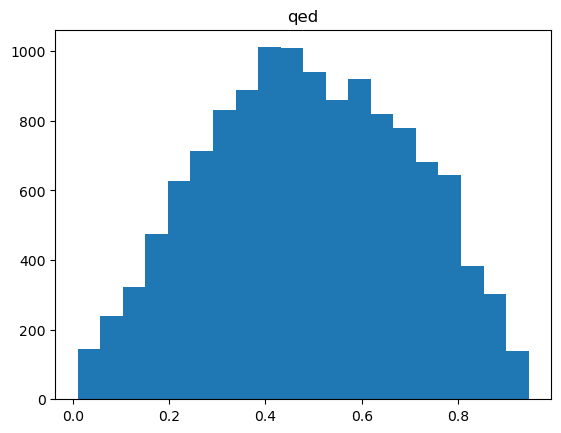

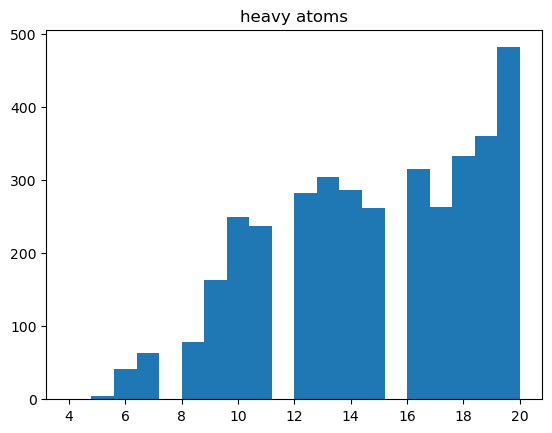

removed_ids: 7440
pdb_ids: 12136
kekul_error 0
valence_error 3
qed_remove 342
ha_remove 109
rare_elem_remove 185


In [ ]:
# apply ligand filters
from rdkit import Chem
from rdkit.Chem import Lipinski
from rdkit.Chem import QED
from rdkit.Chem import AtomKekulizeException, KekulizeException, AtomValenceException
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')  

# this works flawlessly with sdf, but crashes on mol2 due to kekule errors
# I think I should prefer mol2 due to chirality and stuff
# Check if the sdfs actually have aromatic information or if the lack of it is their reason to work that well
#   sdfs do not have any aromatic information

# based on leak-proof pdbbind we remove all ligands containing rare elements (less than 0.1% of entries have that element or 19 in total)
# additionally, B and Fe have been removed since RosettaLigand is not well set up to handle metals
non_rare_elements = ['C', 'S', 'O', 'N', 'Cl', 'P', 'F', 'Br', 'I', 'H']

remaining_pbd_ids = []
qeds = []
ha_counts = []

kekul_error = 0
valence_error = 0
qed_remove = 0
ha_remove = 0
rare_elem_remove = 0

for pdb_code in pdb_ids:
    #mol_path = 'pdbbind_2020plus/' + pdb_code + '/' + pdb_code + '_ligand.mol2'
    #mol = Chem.MolFromMol2File(mol_path, sanitize=True, removeHs=True, cleanupSubstructures=True)
    mol_path = 'pdbbind_2020plus/' + pdb_code + '/' + pdb_code + '_ligand.sdf'
    mol = Chem.MolFromMolFile(mol_path, sanitize=False, removeHs=False)

    removed = False
    try:
        qed = QED.qed(mol)
        qeds.append(qed)
    except (AtomKekulizeException, KekulizeException):
        #print(pdb_code)
        kekul_error += 1
        removed_ids.append((pdb_code, 'kekule'))
        removed = True
    except AtomValenceException:
        valence_error += 1
        removed_ids.append((pdb_code, 'valence'))
        removed = True

    if qed <= 0.1:
        qed_remove += 1
        removed_ids.append((pdb_code, 'qed'))
        removed = True

    numHeavyAtms = Lipinski.HeavyAtomCount(mol)
    ha_counts.append(numHeavyAtms)
    if numHeavyAtms < 8 or numHeavyAtms > 500:
        ha_remove += 1
        removed_ids.append((pdb_code, 'heavy atom count'))
        removed = True

    for atm in mol.GetAtoms():
        if atm.GetSymbol() not in non_rare_elements:
            rare_elem_remove += 1
            removed_ids.append((pdb_code, 'rare element'))
            removed = True

    if not removed:
        remaining_pbd_ids.append(pdb_code)

from matplotlib import pyplot as plt

plt.hist(qeds, bins=20)
plt.title('qed')
plt.show()

plt.hist([c for c in ha_counts if c <= 20], bins=20)
plt.title('heavy atoms')
plt.show()

print('removed_ids:', len(removed_ids))
print('pdb_ids:', len(remaining_pbd_ids))
print('kekul_error', kekul_error)
print('valence_error', valence_error)
print('qed_remove', qed_remove)
print('ha_remove', ha_remove)
print('rare_elem_remove', rare_elem_remove)

In [5]:
# check if sd files contain hydrogens and aromatic bonds

aromatics = 0
aromatic_rdkit = 0
hydrogens = 0

for pdb_id in remaining_pbd_ids:
    sdf_path = 'pdbbind_2020plus/' + pdb_code + '/' + pdb_code + '_ligand.sdf'
    has_hydrogen = False
    has_aromatic = False
    has_aromatic_rdkit = False
    mol = Chem.MolFromMolFile(mol_path, sanitize=True, removeHs=True)
    try:
        aroats = mol.GetAromaticAtoms()
        if len(aroats) > 0:
            has_aromatic_rdkit = True
    except:
        print(pdb_id)
        break
    with open(sdf_path) as file:
        for line in file:
            if len(line) > 50:
                if line[31] == 'H':
                    has_hydrogen = True
            elif len(line) == 19:
                if line[8] == '4':
                    has_aromatic = True
    if has_hydrogen:
        hydrogens += 1
    if has_aromatic:
        aromatics += 1
    if has_aromatic_rdkit:
        aromatic_rdkit += 1
print(hydrogens, 'of', len(remaining_pbd_ids), 'mols have hydrogens')
print(aromatics, 'sdf have aromatic bonds')
print(aromatic_rdkit, 'mols have aromatic bonds after being processed by rdkit')

15098 of 15098 mols have hydrogens
0 sdf have aromatic bonds
15098 mols have aromatic bonds after being processed by rdkit


100%|██████████| 12136/12136 [03:23<00:00, 59.63it/s] 


{'CGA': 1, 'LLP': 59, 'FTR': 1, 'ACE': 1, 'MSE': 61, 'PYR': 6, 'CME': 11, 'OCS': 24, 'KCX': 56, 'CSO': 9, 'CSD': 7, 'ALY': 3, 'FME': 2, 'TPO': 6, 'SEP': 7, 'PCA': 1, 'OCY': 4, 'M3L': 3, 'CMH': 1, 'TRQ': 3, 'MDO': 4, 'MHO': 1, 'CSX': 5, 'TPQ': 3, 'SCY': 1, 'CAS': 15, 'SGB': 1, 'CAF': 12, 'SNC': 1, 'MHS': 1, 'AGM': 1, 'GL3': 1, 'KPI': 1, 'MLY': 5, 'SUN': 1, 'PHQ': 1, '4H0': 1, 'FT6': 1, 'LED': 1, 'YOF': 1, 'PTR': 1, 'PHD': 2, '4AK': 1, 'YCM': 1, 'SNN': 1, 'CSS': 2, 'IAS': 1}
{' ZN': 1448, 'HOH': 11463, ' IN': 1, ' MG': 583, ' CA': 208, 'PLP': 19, ' MN': 247, ' FE': 59, 'FE2': 23, 'BCB': 3, ' NA': 117, '  K': 67, ' NI': 49, ' CU': 9, ' CD': 9, ' CO': 40, 'HEM': 6, 'NAG': 8, ' SR': 1, ' HG': 3, 'ARS': 5, 'MGF': 1, 'F43': 1, ' CS': 1, 'DOD': 8, 'ALF': 1, 'F3S': 1, 'SF4': 5, 'BMA': 1, 'MAN': 1, ' EU': 1}
200
54


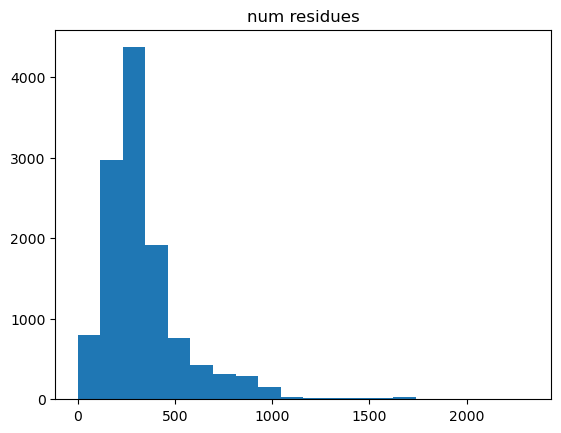

removed_ids: 8034
pdb_ids: 11542
size_removed 200
co_ligand_removed 80
mutated_residue_removed 314


In [7]:
# clean pdb files

from scipy.spatial import cKDTree
from tqdm import tqdm

hetatm_res_close_to_ligand = {}
hetatm_lig_close_to_ligand = {}
protein_sizes = []

# these are metal ions present in the binding pocket which will be kept because they appear at more than 0.1% of all pdbbind structures
keep_ligands = [' ZN', ' MG', ' MN', ' CA', ' NA', '  K', ' FE', ' NI', ' CO', 'FE2', 'HOH']
# these are modified residues in the binding pocket occuring at more than 0.1% entries. They won't be kept for now because Rosettas clean_pdb transfers them to canonical variants
frequent_special_residues = ['MSE', 'LLP', 'KCX', 'OCS', 'CAS']
# watery structures are not problematic, but I will remove waters
remove_from_file = ['HOH']

final_pdbs = []
size_removed = 0
co_ligand_removed = 0
mutated_residue_removed = 0

for pdb_id in tqdm(remaining_pbd_ids):
    sdf_path = 'pdbbind_2020plus/' + pdb_id + '/' + pdb_id + '_ligand.sdf'
    pdb_path = 'pdbbind_2020plus/' + pdb_id + '/' + pdb_id + '_protein.pdb'

    # find all chains and hetatms in contact with the ligand

    # parse all pdb atoms first to build the tree
    atm_pos = []
    atm_chain = []
    atm_names = []
    atm_res = []
    atm_nums = []
    res_nums = []
    counted_terminal_sigs = []

    with open(pdb_path) as file:
        ter_counter = 0
        for line in file:
            is_atom = line[0:4] == 'ATOM'
            is_hetatm = line[0:6] == 'HETATM'

            if line[0:3] == 'TER':
                ter_counter += 1

            if is_atom or is_hetatm:
                chain = line[21]
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                res_name = 'Protein'
                atm_name = 'Protein'
                atm_num = int(line[6:11])
                res_num = int(line[22:26])

            if is_hetatm:
                res_name = line[17:20]
                atm_name = line[12:16]

            if is_atom or is_hetatm:
                atm_pos.append([x, y, z])
                atm_chain.append(chain)
                atm_names.append(atm_name)
                atm_res.append(res_name)
                atm_nums.append(atm_num)
                res_nums.append(res_num)
                counted_terminal_sigs.append(ter_counter)

    # build tree
    tree = cKDTree(atm_pos)

    # parse ligand coordinates
    all_points = set()
    with open(sdf_path) as file:
        for line in file:
            line_arr = line.strip().split()
            if len(line_arr) == 10:
                x = float(line_arr[0])
                y = float(line_arr[1])
                z = float(line_arr[2])

                point_idx = tree.query_ball_point([x, y, z], 7.0)
                all_points.update(point_idx)

    remaining_chains = set()
    additional_residues = set()
    additional_ligands = set()
    non_chain_block_ter_count = max(counted_terminal_sigs)
    for idx in all_points:
        if atm_names[idx] == 'Protein':
            remaining_chains.add(atm_chain[idx])
        else:
            #print(atm_chain[idx], atm_nums[idx], atm_names[idx], atm_res[idx])
            if counted_terminal_sigs[idx] == non_chain_block_ter_count:
                additional_ligands.add(atm_res[idx])
            else:
                additional_residues.add(atm_res[idx])
    
    # count in how many entries a special residue close the ligand is present
    for res in additional_residues:
        if res not in hetatm_res_close_to_ligand:
            hetatm_res_close_to_ligand[res] = 0
        hetatm_res_close_to_ligand[res] += 1

    has_co_ligand = False
    for res in additional_ligands:
        if res not in hetatm_lig_close_to_ligand:
            hetatm_lig_close_to_ligand[res] = 0
        hetatm_lig_close_to_ligand[res] += 1
        if res not in keep_ligands:
            has_co_ligand = True

    size = 0
    for chain in remaining_chains:
        remaining_residues = set()
        for i in range(len(atm_chain)):
            if atm_chain[i] == chain:
                remaining_residues.add(res_nums[i])
        size += len(remaining_residues)
    protein_sizes.append(size)

    if size > 1000:
        removed_ids.append((pdb_id, 'size'))
        size_removed += 1
        continue
    if has_co_ligand:
        removed_ids.append((pdb_id, 'co ligand'))
        co_ligand_removed += 1
        continue
    if len(additional_residues) > 0:
        removed_ids.append((pdb_id, 'mutated residue'))
        mutated_residue_removed += 1
        continue

    final_pdbs.append(pdb_id)

    # TODO: Write code to write clean pdb files
    #       Flag files with water close to ligand

print(hetatm_res_close_to_ligand)
print(hetatm_lig_close_to_ligand)
print(len([s for s in protein_sizes if s > 1000]))
print(len([s for s in protein_sizes if s > 1500]))

plt.hist(protein_sizes, bins=20)
plt.title('num residues')
plt.show()

print('removed_ids:', len(removed_ids))
print('pdb_ids:', len(final_pdbs))
print('size_removed', size_removed)
print('co_ligand_removed', co_ligand_removed)
print('mutated_residue_removed', mutated_residue_removed)

In [8]:
print(sorted([(hetatm_res_close_to_ligand[key], key) for key in hetatm_res_close_to_ligand if hetatm_res_close_to_ligand[key] > 19], reverse=True))
print(sorted([(hetatm_lig_close_to_ligand[key], key) for key in hetatm_lig_close_to_ligand if hetatm_lig_close_to_ligand[key] > 19], reverse=True))

[(61, 'MSE'), (59, 'LLP'), (56, 'KCX'), (24, 'OCS')]
[(11463, 'HOH'), (1448, ' ZN'), (583, ' MG'), (247, ' MN'), (208, ' CA'), (117, ' NA'), (67, '  K'), (59, ' FE'), (49, ' NI'), (40, ' CO'), (23, 'FE2')]
